In [127]:
%matplotlib notebook 

import autograd.numpy as numpy
import autograd.numpy.random as npr

from autograd import grad
from autograd.optimizers import sgd, adam

from autograd.util import flatten_func


import scipy.optimize
import matplotlib.pyplot as plot

from collections import OrderedDict

In [128]:
import matplotlib
matplotlib.rc('text', usetex=True)

In [129]:
numpy.random.seed(1234)

In [130]:
from sklearn.datasets import make_blobs

def label_map(y_, from_, to_):
    y = numpy.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y

n_dim = 2
x_tra, y_tra = make_blobs(n_samples=100, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.7)
x_tes, y_tes = make_blobs(n_samples=100, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.7)

y_tra = label_map(y_tra, [0, 1], 0)
y_tra = label_map(y_tra, [2, 3], 1)
y_tes = label_map(y_tes, [0, 1], 0)
y_tes = label_map(y_tes, [2, 3], 1)

In [131]:
def init_params(n_dim, n_hid, scale=0.01, n_layers=2):
    params = OrderedDict()
    
    indim = n_dim
    
    for li in xrange(n_layers):
        params['w%d'%li] = scale * npr.randn(indim, n_hid)
        params['b%d'%li] = numpy.zeros(n_hid)
        indim = n_hid
    params['u'] = scale * npr.randn(n_hid)
    params['c'] = numpy.zeros(1)
    
    return params

In [132]:
def sigmoid(a):
    return 1. / (1. + numpy.exp(-a))

def relu(a):
    return numpy.maximum(0., a)

def tanh(a):
    return numpy.tanh(a)

In [143]:
def mlp(x, p, pre=False):   
    x = x.reshape([1, -1]) if len(x.shape) < 2 else x
    h = x

    for li in xrange(100):
        if 'w%d'%li not in p:
            break
        h = tanh(numpy.dot(h, p['w%d'%li]) + p['b%d'%li][None,:])
        
    y = numpy.dot(h, p['u']) + p['c']

    if pre:
        return y    
    return sigmoid(y)

In [144]:
def mlp_dist(y, x, p, avg=False):
    y_ = mlp(x, p)
    
    d = -(y * numpy.log(y_+1e-8) + (1. - y) * numpy.log(1-y_+1e-8))
    
    if not avg:
        return d
    return numpy.mean(d)

In [145]:
def cost(p, i):
    return mlp_dist(y_tra, x_tra, p, avg=True)

mlp_rule = grad(cost)

In [146]:
def _callback(p, i, g):
    if numpy.mod(i, 100) == 0:
        print cost(p, i)

In [175]:
params0 = init_params(n_dim=n_dim, n_hid=10, n_layers=1)
flattened_grad, unflatten, p0 = flatten_func(mlp_rule, params0)

def scipy_cost(p, x_tra, y_tra):
    return cost(unflatten(p), 0), flattened_grad(p, 0)

res = scipy.optimize.minimize(scipy_cost, p0, (x_tra, y_tra), method='L-BFGS-B', jac=True)


#params = sgd(mlp_rule, params0, callback=_callback, num_iters=10000, step_size=1., mass=0.9)

In [176]:
params = unflatten(res.x)
print res

      fun: 0.12344897401327104
 hess_inv: <41x41 LbfgsInvHessProduct with dtype=float64>
      jac: array([  4.41247513e-06,  -6.43077051e-08,  -1.36963198e-13,
         8.31771386e-23,   3.47981756e-16,  -3.94534872e-07,
         3.22659874e-10,  -1.24283119e-15,   5.96750321e-09,
        -7.45200037e-14,   4.59190206e-06,   4.55762020e-06,
         5.03893673e-06,   3.86338150e-06,  -4.59190206e-06,
        -4.59190206e-06,   3.40452260e-06,  -3.39984796e-06,
         3.85258303e-06,   3.46644559e-06,  -3.45544485e-06,
         4.86328517e-06,   3.11857525e-06,  -1.17534515e-13,
         1.38758780e-22,  -6.89352146e-16,   7.42862688e-08,
        -5.42703555e-10,   7.74096747e-16,  -1.02849157e-08,
        -2.05898251e-12,   3.38142322e-06,  -1.56396125e-06,
        -7.40723891e-14,  -3.44690240e-23,  -3.72555230e-16,
         2.86961353e-07,  -3.38549186e-10,   2.23128161e-17,
         2.37617288e-09,  -2.40907786e-12])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
 

In [164]:
# visualize data 
def vis_data(x, y = None, c='r'):
    if y is None: 
        y = [None] * len(x)
    plot.hold('on')
    for x_, y_ in zip(x, y):
        if y_ is None:
            plot.plot(x_[0], x_[1], 'o', markerfacecolor='none', markeredgecolor=c)
        else:
            plot.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')
    plot.hold('off')
    plot.grid('on')

In [165]:
def vis_decision_boundary(p, typ='k--'):
    plot.hold('on')

    lim0 = plot.gca().get_xlim()
    lim1 = plot.gca().get_ylim()
    
    x_ = numpy.linspace(lim0[0], lim0[1], 100)
    y_ = numpy.linspace(lim1[0], lim1[1], 100)
    xx, yy = numpy.meshgrid(x_, y_)
    
    pred = mlp(numpy.concatenate([xx.ravel()[:,None], yy.ravel()[:,None]], axis=1), p)
    plt1 = plot.contourf(xx, yy, pred.reshape(xx.shape), cmap=plot.cm.coolwarm, alpha=0.4)

    plot.gca().set_xlim(lim0)
    plot.gca().set_ylim(lim1)
    
    plot.hold('off')
    
    return plt1

<IPython.core.display.Javascript object>


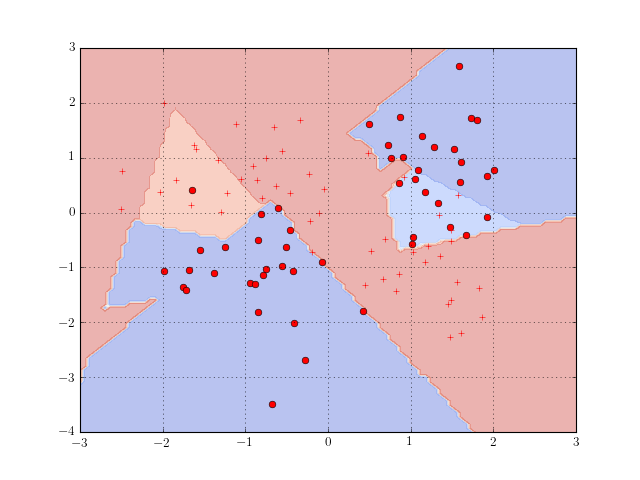

In [166]:
plot.figure()

vis_data(x_tra, y_tra, c='r')

#plt1 = vis_decision_boundary(params0, 'k--')
plt1 = vis_decision_boundary(params, 'k--')

plot.show()

In [64]:
tra_er = numpy.sum(numpy.abs(numpy.round(mlp(x_tra, params)) - y_tra)) / numpy.float(len(y_tra))
tes_er = numpy.sum(numpy.abs(numpy.round(mlp(x_tes, params)) - y_tes)) / numpy.float(len(y_tes))

print 'Training error rate {}, Test error rate {}'.format(tra_er, tes_er)

Training error rate 0.0, Test error rate 0.0
